In [215]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive


In [216]:
import my_utils as mu
import torch
from torch import nn
from IPython import display

In [217]:
# Read training and test data
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
# type(train_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [218]:
X,y = next(iter(train_iter)) #assign training iterable to X,y
print(X.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 1, 28, 28])


In [219]:
patches = X.unfold(2, 14, 14).unfold(3, 14, 14)
#patches = patches.reshape(256, 1, -1, 7, 7)

patches.shape
#patches[0]

torch.Size([256, 1, 2, 2, 14, 14])

In [220]:
lin = nn.Linear(200, 10, bias=False)
parameters = []
for param in lin.parameters():
  parameters.append(param)
parameters = torch.stack(parameters)#concatinate parameters 
parameters

tensor([[[ 0.0493,  0.0340, -0.0425,  ..., -0.0272, -0.0008, -0.0401],
         [ 0.0421,  0.0556, -0.0267,  ..., -0.0589, -0.0553, -0.0175],
         [ 0.0202, -0.0612,  0.0117,  ...,  0.0183, -0.0672, -0.0209],
         ...,
         [ 0.0053, -0.0358, -0.0522,  ..., -0.0141, -0.0148, -0.0218],
         [ 0.0620, -0.0301,  0.0642,  ...,  0.0639,  0.0028, -0.0265],
         [ 0.0631, -0.0133, -0.0431,  ..., -0.0469,  0.0265, -0.0136]]],
       grad_fn=<StackBackward0>)

In [221]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        num_hidden = 200
        self.Linear1 = nn.Linear(num_inputs, num_hidden)#input layer 200 inputs 10 out
        self.relu = nn.ReLU()#activation function set to relu
        self.dropout = nn.Dropout(0.1)
        self.Linear2= nn.Linear(4,200)
        self.Linear3= nn.Linear(200,4)
        self.Linear4= nn.Linear(200,20)
        self.Linear5=nn.Linear(20,10)
    
    #for stem
    def patch(self, batch):#function to perform patching
        final = [] #array instantiated to store the patch
        batch = batch.unfold(2, 14, 14).unfold(3, 14, 14)#batch is unfolded, splits each image into 4 14x14 sections stored in size [256, 1, 2, 2, 14, 14]
        for x in batch:
          tTensor = x.flatten()#flatten x from [1,2,2,14,14] to array 
          tTensor = torch.split(tTensor,196)#.split creates 4 patches 14x14 in size, 
          tTensor = torch.stack(list(tTensor))#stack concatinates the patches
          tTensor.shape
          final.append(tTensor)#appends to final
        final = torch.stack(final)#does the concatenation to turn final into tensor
        return final
    
    def forward(self, x):
        #STEM
        x = self.patch(x)#splits each into 4 28x28 patches
        #print(x.shape)
        first = self.Linear1(x) #input layer with size[256, 4, 200]
        #print("first",first.shape)
        first = torch.transpose(first,1,2)#transposes the input layer to have size[256, 200, 4]
        #print("first tranposed", first.shape)
        #FIRST BLOCK
        second = self.Linear2(first) #w1 with shape [256, 200, 200]
        #print("second shape", second.shape)
        relu2 = self.relu(second)#perform relu activation function on second
        third = self.Linear3(relu2) #pass relu activated layer 2 to layer three with size [256, 200, 4]
        #print("third", third.shape) 
        third = torch.transpose(third,1,2) #tranpose layer three to have shape [256, 4, 200]

      
        #print("transpose",third.shape)
        fourth = self.Linear4(third)#fourth layer has size[256, 4, 20]
        #print(fourth.shape)
        relu4 = self.relu(fourth)#relu activation function on layer 4

        
        fifth = self.Linear5(relu4)# layer 5 has size [256, 4, 10]
        #fifth = self.relu(fifth) not needed
        #print(fifth.shape)
        out = fifth.mean(axis=1)#out has 256 in and 10 outputs[256, 10]
        #print(out.shape)
        return out

In [222]:
# Create and initialize your model here:
num_inputs, num_hidden, num_outputs = 196, 256, 10
net = Net(num_inputs, num_outputs)

# Initialise your model here using init_weights function. If not done, default initiliazation will be used.


In [223]:
def evaluate_accuracy(net, data_iter): #accuracy evaluation from my_utils
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [224]:
def init_weights(m):#initialize weight with xavier_normal
    if type(m) == nn.Linear:     
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


In [225]:
net.apply(init_weights)#apply initialize weight
loss=nn.CrossEntropyLoss()#cross entropy loss

optimizer = torch.optim.Adam(net.parameters(), lr=0.01) #Adam optimizer with learning rate .01

In [226]:
class Accumulator:  #accumulator from my_utils
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [227]:
#accuracy from my_utils
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class. 
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

# Example: only 1 sample is correctly classified.
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
accuracy(y_hat, y) / len(y)

0.5

0.868


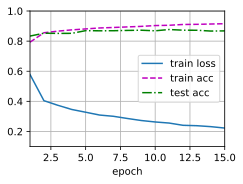

In [228]:
num_epochs = 15 # run for 15 epochs
try:#place in try and except to pass assert error
  mu.train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer) #trainer from my_utils
except AssertionError as e:
  print(e)
  pass 

print(evaluate_accuracy(net, test_iter))



In [229]:
# import matplotlib.pyplot as plt
# import numpy as np
# from torch.utils.data.sampler import SubsetRandomSampler
# print(evaluate_accuracy(net, test_iter))
# #obtin one batch of test images
# dataiter = iter(test_iter)
# images, labels = dataiter.next()

# #get sample outputs
# output = net(images)

# #convert output probablities to predicted  class
# _, pred = torch.max(output, 1)

# #prep images to display

# images = images.numpy()

# #plot the images in batch, along with predicted and true labels
# fig = plt.figure(figsize=(25, 4))
# for idx in np.arange(20):
#     ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
#     ax.imshow(np.squeeze(images[idx]), cmap='gray')
#     ax.set_title("{} ({})".format(str(pred[idx].item()), str(labels[idx].item()))),
#     color=("green" if pred[idx]==labels[idx] else 'red')